In [1]:
# %%capture
import os
import numpy as np
from enum import Enum
import time
import datetime
import keras.layers as keras_layers

from vqa_logger import logger

c:\local\Anaconda3-4.1.1-Windows-x86_64\envs\conda_env\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from common.os_utils import File
from common.settings import classify_strategy, embedded_sentence_length, get_stratagy_str
from common.classes import ClassifyStrategies, VqaSpecs
from common.model_utils import save_model
from common.constatns import vqa_models_folder, vqa_specs_location

In [3]:
DEFAULT_IMAGE_WIEGHTS = 'imagenet'
#  Since VGG was trained as a image of 224x224, every new image
# is required to go through the same transformation
image_size_by_base_models = {'imagenet': (224, 224)}

In [4]:
#Available merge strategies:
# keras_layers.multiply, keras_layers.add, keras_layers.concatenate, 
# keras_layers.average, keras_layers.co, keras_layers.dot, keras_layers.maximum
            
merge_strategy = keras_layers.concatenate

In [5]:
vqa_specs = File.load_pickle(vqa_specs_location)
meta_data = vqa_specs.meta_data


Before we start, just for making sure, lets clear the session:

In [6]:
from keras import backend as keras_backend
keras_backend.clear_session()

### Creating the model

#### The functions the gets the model:

Define how to build the word-to vector branch:

In [7]:
def word_2_vec_model(input_tensor):
        # notes:
        # num works: scalar represents size of original corpus
        # embedding_dim : dim reduction. every input string will be encoded in a binary fashion using a vector of this length
        # embedding_matrix (AKA embedding_initializers): represents a pre trained network

        LSTM_UNITS = 512
        DENSE_UNITS = 1024
        DENSE_ACTIVATION = 'relu'


        # logger.debug("Creating Embedding model")
        # x = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=seq_length,trainable=False)(input_tensor)
        # x = LSTM(units=LSTM_UNITS, return_sequences=True, input_shape=(seq_length, embedding_dim))(x)
        # x = BatchNormalization()(x)
        # x = LSTM(units=LSTM_UNITS, return_sequences=False)(x)
        # x = BatchNormalization()(x)
        x= input_tensor # Since using spacy
        x = Dense(units=DENSE_UNITS, activation=DENSE_ACTIVATION)(x)
        model = x
        logger.debug("Done Creating Embedding model")
        return model

In the same manner, define how to build the image representation branch:

In [8]:
from keras.applications.vgg19 import VGG19
from keras.layers import Dense, GlobalAveragePooling2D#, Input, Dropout
def get_image_model(base_model_weights=DEFAULT_IMAGE_WIEGHTS, out_put_dim=1024):
    base_model_weights = base_model_weights

    # base_model = VGG19(weights=base_model_weights,include_top=False)
    base_model = VGG19(weights=base_model_weights, include_top=False)
    base_model.trainable = False
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    # add a global spatial average pooling layer
    x = GlobalAveragePooling2D(name="image_model_average_pool")(x)
    # let's add a fully-connected layer
    x = Dense(out_put_dim, activation='relu',name="image_model_dense")(x)
    # and a logistic layer -- let's say we have 200 classes
    # predictions = Dense(200, activation='softmax')(x)
    model = x
    
    return base_model.input , model

And finally, building the model itself:

In [9]:
model_output_num_units = None
if classify_strategy == ClassifyStrategies.CATEGORIAL:    
    model_output_num_units = len(list(meta_data['ix_to_ans'].keys()) )
elif classify_strategy == ClassifyStrategies.NLP:
    model_output_num_units = embedded_sentence_length    
else:
    raise Exception(f'Unfamilier strategy: {strat}')

logger.debug(f'Model will have {model_output_num_units} output units (Strategy: {classify_strategy})')

[09:48:12][DEBUG] Model will have 12288 output units (Strategy: ClassifyStrategies.NLP)


In [10]:
from keras import Model, models, Input, callbacks
from keras.utils import plot_model, to_categorical
from keras.layers import Dense, Embedding, LSTM, BatchNormalization#, GlobalAveragePooling2D, Merge, Flatten

def get_vqa_model(meta):
#     import tensorflow as tf
#     g = tf.Graph()
#     with g.as_default():
    DENSE_UNITS = 1000
    DENSE_ACTIVATION = 'relu'

    OPTIMIZER = 'rmsprop'
    LOSS = 'categorical_crossentropy'
    METRICS = 'accuracy'
    num_classes = len(meta['ix_to_ans'].keys())
    image_model, lstm_model, fc_model = None, None, None
    try:     
        # ATTN:
        lstm_input_tensor = Input(shape=(embedded_sentence_length,), name='embedding_input')
        #lstm_input_tensor = Input(shape=(embedding_dim,), name='embedding_input')

        logger.debug("Getting embedding (lstm model)")
        lstm_model = word_2_vec_model(input_tensor=lstm_input_tensor)

        logger.debug("Getting image model")
        out_put_dim = lstm_model.shape[-1].value
        image_input_tensor, image_model = get_image_model(out_put_dim=out_put_dim)


        logger.debug("merging final model")
        fc_tensors = merge_strategy(inputs=[image_model, lstm_model])
        fc_tensors = BatchNormalization()(fc_tensors)
        fc_tensors = Dense(units=DENSE_UNITS, activation=DENSE_ACTIVATION)(fc_tensors)
        fc_tensors = BatchNormalization()(fc_tensors)

        #ATTN:
        fc_tensors = Dense(units=embedded_sentence_length, activation='softmax', name='model_output_sofmax_dense')(fc_tensors)
        #fc_tensors = Dense(units=num_classes, activation='softmax', name='model_output_sofmax_dense')(fc_tensors)

        fc_model = Model(inputs=[lstm_input_tensor, image_input_tensor], output=fc_tensors)
        fc_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[METRICS])
    except Exception as ex:
        logger.error("Got an error while building vqa model:\n{0}".format(ex))
        models = [(image_model, 'image_model'), (lstm_model, 'lstm_model'), (fc_model, 'lstm_model')]
        for m, name in models:
            if m is not None:
                logger.error("######################### {0} model details: ######################### ".format(name))
                try:
                    m.summary(print_fn=logger.error)
                except Exception as ex2:
                    logger.warning("Failed to print summary for {0}:\n{1}".format(name, ex2))
        raise

    return fc_model

model = get_vqa_model(meta_data)
model


[09:48:12][DEBUG] Getting embedding (lstm model)
[09:48:12][DEBUG] Done Creating Embedding model
[09:48:12][DEBUG] Getting image model
[09:48:14][DEBUG] merging final model


c:\local\Anaconda3-4.1.1-Windows-x86_64\envs\conda_env\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mo...)`


We better save it:

In [11]:
strategy_str = get_stratagy_str()

model_fn, summary_fn, fn_image = save_model(model, vqa_models_folder, name_suffix=strategy_str)

msg = f"Summary: {summary_fn}\n"
msg += f"Image: {fn_image}\n"
location_message = f"model_location = '{model_fn}'"


print(msg)
print (location_message)

[09:48:14][DEBUG] saving model to: 'C:\Users\Public\Documents\Data\2018\vqa_models\20180629_0948_14\vqa_model_NLP.h5'
[09:48:14][DEBUG] saving model image to C:\Users\Public\Documents\Data\2018\vqa_models\20180629_0948_14\model.png
[09:48:15][DEBUG] model saved
[09:48:15][DEBUG] Writing Symmary
[09:48:15][DEBUG] Done Writing Summary
[09:48:15][DEBUG] Saving image
[09:48:15][DEBUG] Image saved ('C:\Users\Public\Documents\Data\2018\vqa_models\20180629_0948_14\model.png')
Summary: C:\Users\Public\Documents\Data\2018\vqa_models\20180629_0948_14\model_summary.txt
Image: C:\Users\Public\Documents\Data\2018\vqa_models\20180629_0948_14\model.png

model_location = 'C:\Users\Public\Documents\Data\2018\vqa_models\20180629_0948_14\vqa_model_NLP.h5'


Display a plot + summary:

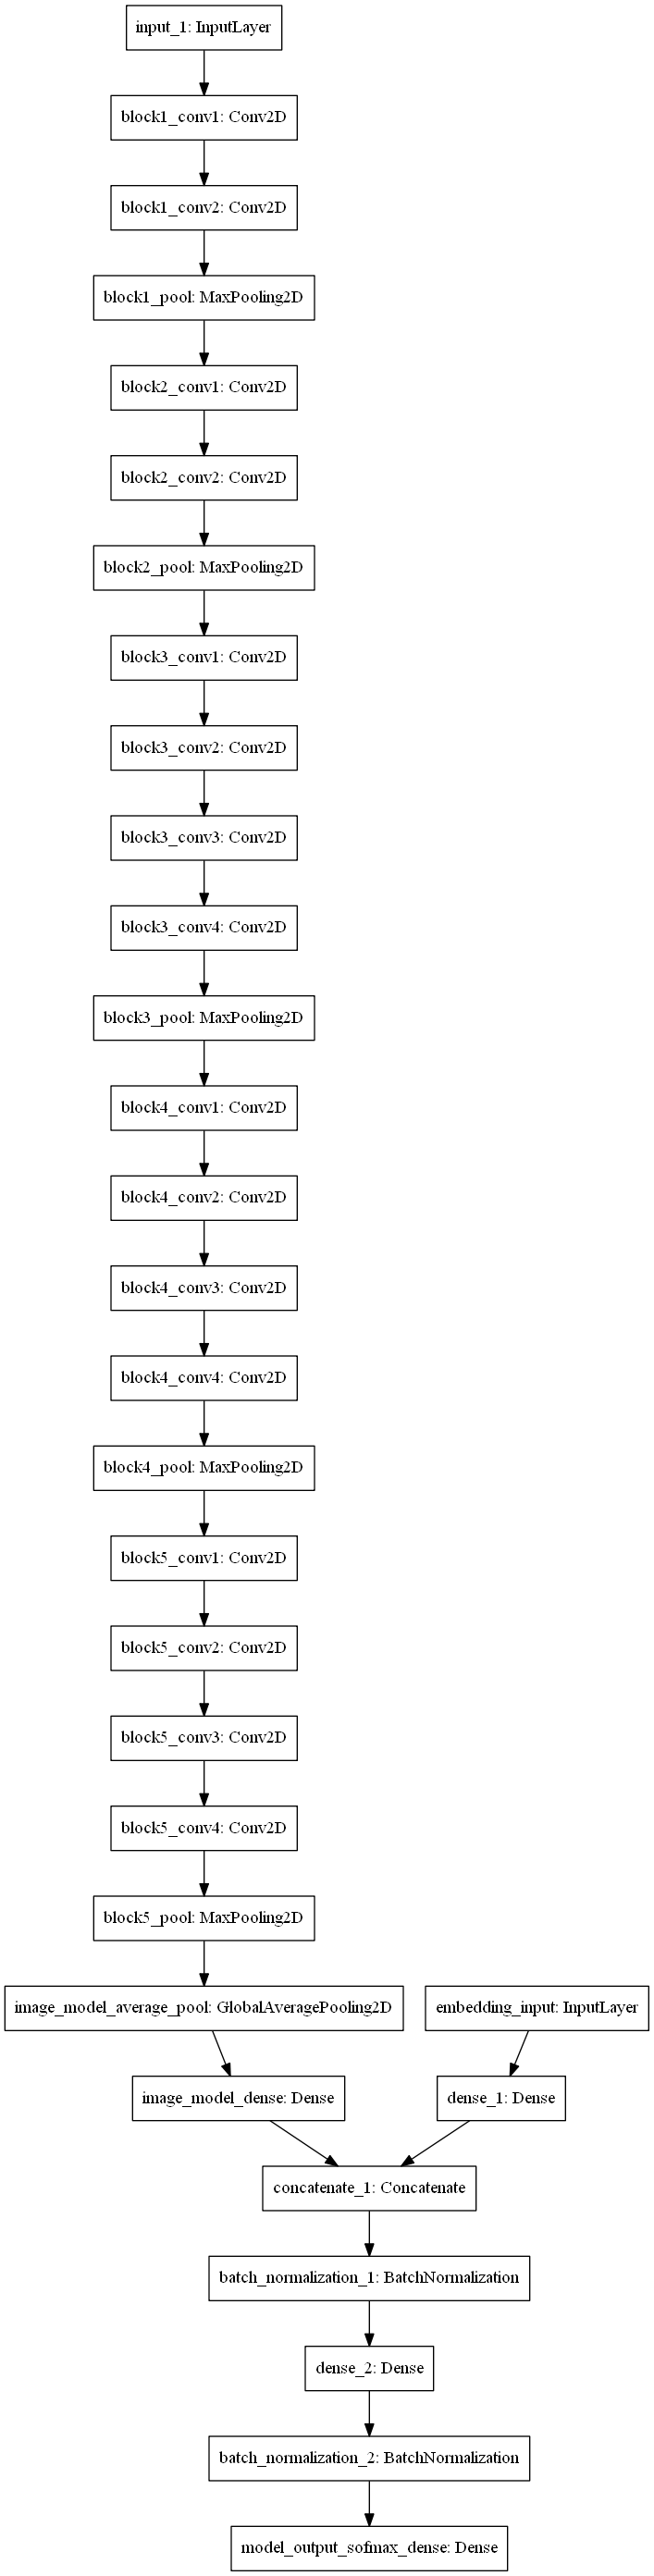

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [12]:
# %matplotlib inline
# from matplotlib import pyplot as plt
# %pylab inline


# plt.imshow(img,cmap='gray')
# plt.show()

from IPython.display import Image, display

listOfImageNames = [fn_image]

for imageName in listOfImageNames:
    display(Image(filename=imageName))
model.summary()

Copy these items to the next notebook of training the model

In [19]:
logger.debug('Done')
print(location_message.replace('\\', '\\\\'))
print(f'strategy_str = \'{strategy_str}\'')


[09:49:37][DEBUG] Done
model_location = 'C:\\Users\\Public\\Documents\\Data\\2018\\vqa_models\\20180629_0948_14\\vqa_model_NLP.h5'
strategy_str = 'NLP'
